In [1]:
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse import save_npz

import json
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

import torch

from transformers import AutoTokenizer, AutoModel

In [2]:
data_dir = '2021-07-19'

In [3]:
# lemmatizer = WordNetLemmatizer()
# lemmatize = lambda sent: ' '.join(list(map(lambda word: lemmatizer.lemmatize(word), word_tokenize(sent))))

In [4]:
# tokenizer.convert_ids_to_tokens(lemmatize(data.at[0,'concat_title_abs'])['input_ids'][0])

In [5]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
lemmatize = lambda sent: ' '.join(tokenizer.convert_ids_to_tokens(
                            tokenizer([sent], padding=False, truncation=False, 
                                      return_tensors=None,return_attention_mask=False,
                                      add_special_tokens=False)['input_ids'][0]
                        ))

In [6]:
data = pd.read_csv(f'scibert_encoded_papers/needed_paper_metadata_{data_dir}.csv')

In [7]:
data.fillna(' ',inplace=True)

In [8]:
data['concat_title_abs'] =data[['title', 'abstract']].agg('. '.join, axis=1)

In [9]:
data.drop(columns=['title','abstract'],inplace=True)

In [10]:
data.at[0,'concat_title_abs']

'Database resources of the National Center for Biotechnology Information. The National Center for Biotechnology Information (NCBI) provides a large suite of online resources for biological information and data, including the GenBank(®) nucleic acid sequence database and the PubMed database of citations and abstracts for published life science journals. Additional NCBI resources focus on literature (PubMed Central (PMC), Bookshelf and PubReader), health (ClinVar, dbGaP, dbMHC, the Genetic Testing Registry, HIV-1/Human Protein Interaction Database and MedGen), genomes (BioProject, Assembly, Genome, BioSample, dbSNP, dbVar, Epigenomics, the Map Viewer, Nucleotide, Probe, RefSeq, Sequence Read Archive, the Taxonomy Browser and the Trace Archive), genes (Gene, Gene Expression Omnibus (GEO), HomoloGene, PopSet and UniGene), proteins (Protein, the Conserved Domain Database (CDD), COBALT, Conserved Domain Architecture Retrieval Tool (CDART), the Molecular Modeling Database (MMDB) and Protein C

In [11]:
# lemmatize(data.at[0,'concat_title_abs'])

In [12]:
data['concat_title_abs'] = data['concat_title_abs'].apply(lemmatize)

In [13]:
data.at[0,'concat_title_abs']

'database resources of the national center for biotechnology information . the national center for biotechnology information ( ncbi ) provides a large suite of online resources for biological information and data , including the genbank ( ® ) nucleic acid sequence database and the pubmed database of citations and abstracts for published life science journals . additional ncbi resources focus on literature ( pubmed central ( pmc ) , books ##hel ##f and pub ##read ##er ) , health ( clin ##var , db ##gap , dbm ##hc , the genetic testing registry , hiv - 1 / human protein interaction database and med ##gen ) , genomes ( biop ##ro ##ject , assembly , genome , bios ##ample , dbs ##np , db ##var , epi ##gen ##omics , the map viewer , nucleotide , probe , refs ##eq , sequence read archive , the taxonomy browser and the trace archive ) , genes ( gene , gene expression omn ##ibus ( geo ) , homolog ##ene , pop ##set and uni ##gene ) , proteins ( protein , the conserved domain database ( cd ##d ) 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data['concat_title_abs'].to_list()
vectorizer = TfidfVectorizer(min_df=3)
X = vectorizer.fit_transform(corpus)

In [15]:
print(f"number of words: {len(vectorizer.get_feature_names())}")

number of words: 20091


In [40]:
now = []
for i in tqdm(range(100)):
    vectorizer = TfidfVectorizer(min_df=i)
    X = vectorizer.fit_transform(corpus)
    now.append(len(vectorizer.get_feature_names()))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:24<00:00,  8.64s/it]


In [41]:
from matplotlib import pyplot as plt

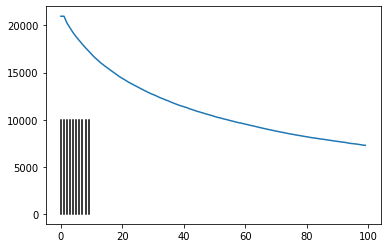

In [42]:
plt.plot(now)
for i in range(10):
    plt.plot([i,i],[0,10000],color='black')

In [16]:
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)

In [17]:
type(csc_matrix(X))

scipy.sparse.csc.csc_matrix

In [18]:
df = pd.DataFrame.sparse.from_spmatrix(X,columns=vectorizer.get_feature_names(),index=data['cord_uid'].to_list())

In [19]:
data.at[0,'concat_title_abs']

'database resources of the national center for biotechnology information . the national center for biotechnology information ( ncbi ) provides a large suite of online resources for biological information and data , including the genbank ( ® ) nucleic acid sequence database and the pubmed database of citations and abstracts for published life science journals . additional ncbi resources focus on literature ( pubmed central ( pmc ) , books ##hel ##f and pub ##read ##er ) , health ( clin ##var , db ##gap , dbm ##hc , the genetic testing registry , hiv - 1 / human protein interaction database and med ##gen ) , genomes ( biop ##ro ##ject , assembly , genome , bios ##ample , dbs ##np , db ##var , epi ##gen ##omics , the map viewer , nucleotide , probe , refs ##eq , sequence read archive , the taxonomy browser and the trace archive ) , genes ( gene , gene expression omn ##ibus ( geo ) , homolog ##ene , pop ##set and uni ##gene ) , proteins ( protein , the conserved domain database ( cd ##d ) 

In [20]:
df.loc['a564l6vs','national']

0.07584667287752428

In [22]:
save_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz', X)

with open(f'tf-idf-results/index_{data_dir}_scibert_token','w',encoding='utf-8') as fw:
    fw.write(json.dumps(df.index.to_list(),indent=1))

with open(f'tf-idf-results/column_{data_dir}_scibert_token','w',encoding='utf-8') as fw:
    fw.write(json.dumps(df.columns.to_list(),indent=1))